In [1]:
from IPython.display import HTML
HTML('''<script>
code_show_err=false; 
function code_toggle_err() {
 if (code_show_err){
 $('div.output_stderr').hide();
 } else {
 $('div.output_stderr').show();
 }
 code_show_err = !code_show_err
} 
$( document ).ready(code_toggle_err);
</script>
To toggle on/off output_stderr, click <a href="javascript:code_toggle_err()">here</a>.''')

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error
from polire.interpolate import  Kriging, Idw
import sys
import gpflow
import tensorflow as tf

In [4]:
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)

In [5]:
df = pd.read_csv("../data/beijinga_scaled.csv")
df = df.loc[:, ~df.columns.str.match('Unnamed')]
df = df.rename(columns={'ts': 'Time', 'station_id': 'Station'})
timestamps = df['Time'].unique()
timestamps.sort()
stations = df['Station'].unique()
stations.sort()


In [6]:
df.head()

,latitude,longitude,Time,Station,PM2.5
0,0.58292,0.17557,0.000000,1001.0,156.250000
1,0.58292,0.17557,0.002747,1001.0,24.833333
2,0.58292,0.17557,0.005495,1001.0,72.583333
3,0.58292,0.17557,0.008242,1001.0,30.043478
4,0.58292,0.17557,0.010989,1001.0,23.083333


In [7]:
stations = df['Station'].unique()
stations.sort()


In [8]:
from sklearn.model_selection import KFold
kf = KFold(n_splits = 6, shuffle = True, random_state = 0)
timestamps = df['Time'].unique()
timestamps.sort()

In [58]:
k = 100

In [59]:
splits = 6

In [60]:
rmse = {'GP':{timestamps[i]:{i:np.nan for i in range(splits)} for i in range(k, len(timestamps))}, 'IDW':{timestamps[i]:{i:np.nan for i in range(splits)} for i in range(k, len(timestamps))}, 'Krig':{timestamps[i]:{i:np.nan for i in range(splits)} for i in range(k, len(timestamps))}}
mae = {'GP':{timestamps[i]:{i:np.nan for i in range(splits)} for i in range(k, len(timestamps))}, 'IDW':{timestamps[i]:{i:np.nan for i in range(splits)} for i in range(k, len(timestamps))}, 'Krig':{timestamps[i]:{i:np.nan for i in range(splits)} for i in range(k, len(timestamps))}}

In [61]:


for idx in range(k, len(timestamps)):
    
    print(timestamps[idx])
    timestamp = timestamps[idx]

    i = -1 

    for train_index, test_index in kf.split(stations):
        i = i + 1
        train_stations = stations[train_index]
        test_stations = stations[test_index]
        try:
            train_df = pd.concat([df.groupby('Station').get_group(stn) for stn in train_stations])
            train_df = train_df.groupby('Time').get_group(timestamp)
            train_df.drop(columns = ['Station', 'Time'])
            test_df = pd.concat([df.groupby('Station').get_group(stn) for stn in test_stations])
            test_df = test_df.groupby('Time').get_group(timestamp)
            test_df.drop(columns = ['Station', 'Time'])

        except KeyError:
            print("No train or test data for,", timestamp)
            continue


        X_train = np.array(train_df[['longitude', 'latitude']])
        y_train = np.array(train_df[['PM2.5']])
        X_test = np.array(test_df[['longitude', 'latitude']])
        y_test = np.array(test_df[['PM2.5']])

        idw = Idw()
        idw.fit(X_train, y_train)
        krig = Kriging()
        krig.fit(X_train, y_train)
        
        gp_train_df = []
        last_k = timestamps[idx - k + 1: idx + 1]
        
        for station in train_stations:
            station_df = df.groupby('Station').get_group(station)
            
            for tme in last_k:
                try:
                    temp = station_df.groupby('Time').get_group(tme)
                    gp_train_df.append(temp)
                except KeyError:
                    continue
                
        tf.reset_default_graph()
        graph = tf.get_default_graph()
        gpflow.reset_default_session(graph=graph)



        xy_matern_1 = gpflow.kernels.Matern52(input_dim=2, ARD=True, active_dims=[0, 1])
        xy_matern_2 = gpflow.kernels.Matern52(input_dim=2, ARD=True, active_dims=[0, 1])

        t_matern = gpflow.kernels.Matern52(input_dim=1, active_dims=[2])
        t_other = gpflow.kernels.Matern52(input_dim=1, active_dims=[2])*gpflow.kernels.Periodic(input_dim=1, active_dims=[2])\
        + gpflow.kernels.Matern12(input_dim=1, active_dims=[2])*gpflow.kernels.Periodic(input_dim=1, active_dims=[2])\
        + gpflow.kernels.Matern32(input_dim=1, active_dims=[2])*gpflow.kernels.Periodic(input_dim=1, active_dims=[2])\

        time = t_matern + t_other
        overall_kernel = (xy_matern_1 + xy_matern_2) * time 

                        
        gp_train_df = pd.concat(gp_train_df)
        X_train_gp = np.array(gp_train_df[['longitude', 'latitude', 'Time']])
        y_train_gp = np.array(gp_train_df[['PM2.5']])
        

        model = gpflow.models.GPR(X_train_gp, y_train_gp, kern = overall_kernel, mean_function = None)
        opt = gpflow.train.ScipyOptimizer()
        opt.minimize(model)

        mean, variance = model.predict_y(X_test)


        gp_rmse_error = np.sqrt(mean_squared_error(mean, y_test))
        gp_mae_error = mean_absolute_error(mean, y_test)
        
        krig_rmse_error = np.sqrt(mean_squared_error(krig.predict(X_test), y_test))
        krig_mae_error = mean_absolute_error(krig.predict(X_test), y_test)
        
        idw_rmse_error = np.sqrt(mean_squared_error(idw.predict(X_test), y_test))
        idw_mae_error = mean_absolute_error(idw.predict(X_test), y_test)
        
        rmse['GP'][timestamp][i] = gp_rmse_error
        mae['GP'][timestamp][i] = gp_mae_error
        
        rmse['Krig'][timestamp][i] = krig_rmse_error
        mae['Krig'][timestamp][i] = krig_mae_error
        
        rmse['IDW'][timestamp][i] = idw_rmse_error
        mae['IDW'][timestamp][i] = idw_mae_error
        
        print(timestamp, "-----", "GP", "-----", gp_rmse_error, "\nIDW -------", idw_rmse_error, "\nKrig-----", krig_rmse_error)

0.28296703296703296


KeyboardInterrupt: 

In [37]:
timestamp

0.0989010989010989

In [38]:
train_stations


array([1001., 1002., 1004., 1005., 1006., 1007., 1008., 1009., 1010.,
       1013., 1014., 1015., 1016., 1017., 1018., 1019., 1020., 1021.,
       1022., 1023., 1024., 1025., 1026., 1027., 1029., 1031., 1032.,
       1033., 1034., 1035.])

In [40]:
df[~df['Station'].isin(train_stations)].groupby('Time').get_group(timestamp)


,latitude,longitude,Time,Station,PM2.5
1418,0.402869,0.184878,0.098901,1003.0,60.291667
2470,0.343164,0.344783,0.098901,1011.0,71.750000
4192,0.426066,0.425734,0.098901,1012.0,60.416667
9429,0.788560,0.216029,0.098901,1030.0,43.619048
11186,0.868232,0.749128,0.098901,1028.0,40.181818


In [48]:
t1 = df[df['Station'].isin(train_stations)].groupby('Time').get_group(timestamp)
t2 = df[~df['Station'].isin(train_stations)].groupby('Time').get_group(timestamp)

In [54]:
import matplotlib.pyplot as plt

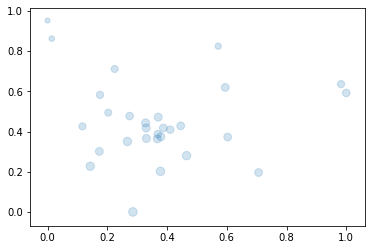

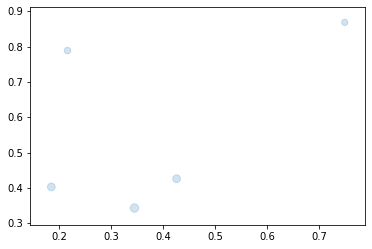

In [57]:
plt.scatter(t1['longitude'], t1['latitude'], t1['PM2.5'], alpha = 0.2)
plt.figure()
plt.scatter(t2['longitude'], t2['latitude'], t2['PM2.5'], alpha = 0.2)

In [44]:
df[df['Station'].isin(test_stations)].groupby('Time').get_group(timestamp)

,latitude,longitude,Time,Station,PM2.5
1418,0.402869,0.184878,0.098901,1003.0,60.291667
2470,0.343164,0.344783,0.098901,1011.0,71.750000
4192,0.426066,0.425734,0.098901,1012.0,60.416667
9429,0.788560,0.216029,0.098901,1030.0,43.619048
11186,0.868232,0.749128,0.098901,1028.0,40.181818


In [34]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
      # Restrict TensorFlow to only use the first GPU
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    except RuntimeError as e:
        # Visible devices must be set at program startup
        print(e)
